# Imports

In [1]:
from data_classes import LAQNData, HealthData, MetData
from os import path
import pandas as pd
import matplotlib.pyplot as plt

# Load data

### Load the hourly NO$_2$ data

In [2]:
data_folder = path.join(path.abspath(""), "LAQN_data")
species = "NO2"
url = "http://api.erg.kcl.ac.uk/AirQuality/Information/MonitoringSites/GroupName=London/Json"
start_date = "2000-01-01"
end_date = "2021-01-01"

In [3]:
NO2_hourly = LAQNData(url, data_folder, species, start_date, end_date)

In [4]:
hourly_NO2_df = NO2_hourly.read_csv(index_col="date")
print(hourly_NO2_df.shape)

Reading NO2_hourly_2000-01-01_2021-01-01.csv...
(184105, 192)


### Load the hourly meteorology data

In [5]:
data_folder = path.join(path.abspath(""), "met_data")
url = "https://bulk.meteostat.net/hourly/03772.csv.gz"

In [6]:
heathrow = MetData(data_folder, url=url)

In [7]:
hourly_met_df = heathrow.read_csv()
print(hourly_met_df.shape)

Reading hourly_heathrow_met_data.csv...
(510165, 8)


### Load the daily mortality per capita data

In [8]:
data_folder = path.join(path.abspath(""), "mortality_data/daily")
filename = "daily_mortality_percapita_London.csv"

In [9]:
mortality_daily = HealthData(data_folder, filename=filename)

In [10]:
mortality_df = pd.DataFrame(mortality_daily.read_csv(index_col="date"))
print(mortality_df.shape)

Reading daily_mortality_percapita_London.csv...
(13698, 3)


# Process data + plots

## Daily data

In [11]:
daily_dates = mortality_df.index

### Resample the hourly NO$_2$ data using a custom date list

Only retain the NO$_2$ data up to the final mortality datapoint:

In [12]:
hourly_NO2_df = hourly_NO2_df.loc[hourly_NO2_df.index < daily_dates.max()]

In [13]:
daily_NO2_df = hourly_NO2_df.groupby(daily_dates[daily_dates.searchsorted(hourly_NO2_df.index)]).mean()

We've now generated a dataframe of weekly mean NO$_2$ concentrations (from the hourly data) using the weekly dates given by the mortality dataset. 
- The `searchsorted()` function takes the `hourly_df` index and inserts it into `weekly_dates` to return an array of indices where the hourly elements should be inserted to maintain order in the weekly dates. See docs [here](https://pandas.pydata.org/pandas-docs/version/0.21.1/generated/pandas.DatetimeIndex.searchsorted.html).
- Placing these indices inside `weekly_dates[]` produces an array the same length as the hourly index, where each entry is the corresponding "weekly" date.
- The `groupby()` operation then performs the `mean()` function on the hourly data, grouping by the assigned weekly dates in the previous step. See docs [here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html).

In [14]:
daily_NO2_df.shape

(6940, 192)

### Spatially average the NO$_2$ data for all of London

In [15]:
NO2_df = pd.DataFrame(daily_NO2_df.mean(axis=1), columns=["mean_NO2"]).join(mortality_df)
NO2_df["deaths_per_100k"] = NO2_df["deaths_per_capita"]*100000

In [16]:
NO2_df.head()

,mean_NO2,total_population,deaths,deaths_per_capita,deaths_per_100k
date,,,,,
2000-01-01,44.654545,7.195538e+06,327,0.000045,4.544483
2000-01-02,52.885482,7.195764e+06,291,0.000040,4.044046
2000-01-03,42.606277,7.195991e+06,312,0.000043,4.335748
2000-01-04,36.740944,7.196217e+06,288,0.000040,4.002103
2000-01-05,64.076266,7.196443e+06,305,0.000042,4.238205


#### Scatter plot mortality vs NO$_2$

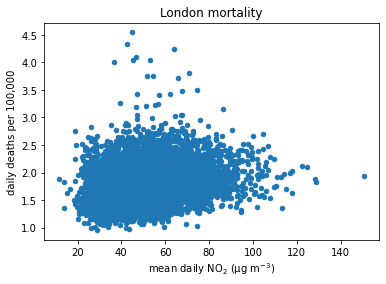

In [17]:
NO2_df.plot.scatter(x="mean_NO2", y="deaths_per_100k", legend=False, title="London mortality").set_ylabel("daily deaths per 100,000")
plt.xlabel("mean daily NO$_2$ (µg m$^{-3}$)")
plt.show()

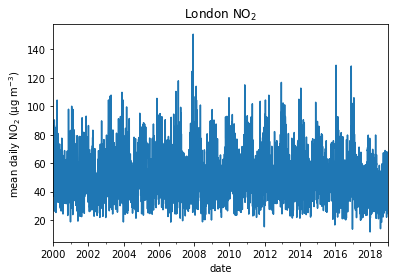

In [18]:
NO2_df.plot(y="mean_NO2", legend=False, title="London NO$_2$").set_ylabel("mean daily NO$_2$ (µg m$^{-3}$)")
plt.show()

### Resample the hourly meteorology data using a custom date list

Only retain the met data up to the final mortality datapoint:

In [19]:
hourly_met_df = hourly_met_df.loc[hourly_met_df.index < daily_dates.max()]

In [20]:
daily_met_df = hourly_met_df.groupby(daily_dates[daily_dates.searchsorted(hourly_met_df.index)]).mean()

In [21]:
daily_met_df.shape

(13695, 8)

In [22]:
daily_met_df.head()

,temperature,dew_point,humidity,precip,wind_dir,wind_speed,peak_gust,pressure
date,,,,,,,,
1981-07-01,10.312016,6.583121,79.670071,NaN,203.286583,14.983545,NaN,1015.472753
1981-07-02,15.833333,10.858333,73.500000,NaN,246.666667,14.358333,NaN,1011.950000
1981-07-03,14.125000,8.091667,68.375000,NaN,218.333333,12.200000,NaN,1007.587500
1981-07-04,14.416667,9.745833,74.875000,NaN,236.250000,13.970833,NaN,1008.373913
1981-07-05,15.416667,12.437500,83.000000,NaN,208.750000,9.379167,NaN,1016.883333


In [23]:
temperature_df = pd.DataFrame(daily_met_df["temperature"]).join(mortality_df)
temperature_df["deaths_per_100k"] = temperature_df["deaths_per_capita"]*100000

In [24]:
temperature_df.head()

,temperature,total_population,deaths,deaths_per_capita,deaths_per_100k
date,,,,,
1981-07-01,10.312016,6.805000e+06,177,0.000026,2.601029
1981-07-02,15.833333,6.804891e+06,204,0.000030,2.997844
1981-07-03,14.125000,6.804781e+06,199,0.000029,2.924414
1981-07-04,14.416667,6.804672e+06,197,0.000029,2.895070
1981-07-05,15.416667,6.804563e+06,191,0.000028,2.806940


#### Scatter plot of mortality vs temperature

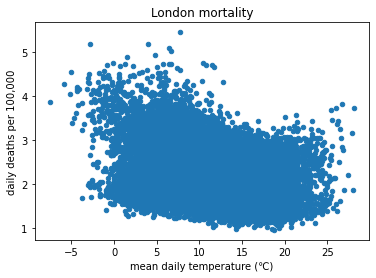

In [25]:
temperature_df.plot.scatter(x="temperature", y="deaths_per_100k", legend=False, title="London mortality").set_ylabel("daily deaths per 100,000")
plt.xlabel("mean daily temperature (℃)")
plt.show()

### Scatter plot of NO$_2$ vs temperature

In [26]:
df = pd.DataFrame(NO2_df["mean_NO2"]).join(temperature_df)

In [27]:
df

,mean_NO2,temperature,total_population,deaths,deaths_per_capita,deaths_per_100k
date,,,,,,
2000-01-01,44.654545,5.966667,7.195538e+06,327,0.000045,4.544483
2000-01-02,52.885482,7.970833,7.195764e+06,291,0.000040,4.044046
2000-01-03,42.606277,8.495833,7.195991e+06,312,0.000043,4.335748
2000-01-04,36.740944,8.904167,7.196217e+06,288,0.000040,4.002103
2000-01-05,64.076266,5.358333,7.196443e+06,305,0.000042,4.238205
...,...,...,...,...,...,...
2018-12-27,43.737685,7.933333,8.934518e+06,129,0.000014,1.443838
2018-12-28,67.491127,5.020833,8.934666e+06,162,0.000018,1.813162
2018-12-29,56.728079,7.925000,8.934813e+06,161,0.000018,1.801940


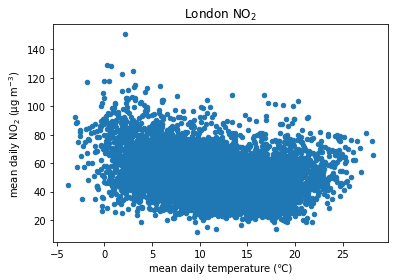

In [30]:
df.plot.scatter(x="temperature", y="mean_NO2", legend=False, title="London NO$_2$").set_ylabel("mean daily NO$_2$ (µg m$^{-3}$)")
plt.xlabel("mean daily temperature (℃)")
plt.show()